**Dataset Description**


You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic

- severe_toxic

- obscene

- threat

- insult

- identity_hate

Link for Dataset:

[Kaggle_Dataset](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data?select=train.csv.zip)





**Import Modules**

In [2]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report


**Loading the Dataset**

In [3]:

df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Dataset Stats**

In [4]:

df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Dataset Info**

In [5]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


**Checking the data for null values**

In [6]:

df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
len(df)


159571

**Exploratory Data Analysis**

In [8]:

x = df.iloc[:, 2:].sum() # take only label columns
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [9]:
rowsums = df.iloc[:, 2:].sum(axis=1) # take label columns and sum it column wise
rowsums

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

In [10]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1
        
print('Total number of comments:', len(df))
print('Total number of comments without labels:', no_label_count)
print('Total labels:', x.sum())

Total number of comments: 159571
Total number of comments without labels: 143346
Total labels: 35098


C:\Users\venki\AppData\Local\Temp\ipykernel_2780\794052374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])


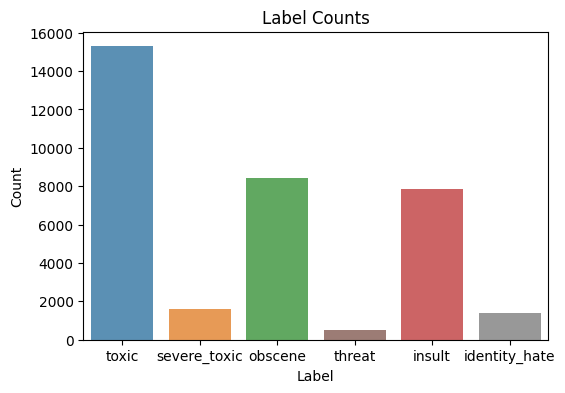

In [11]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()


C:\Users\venki\AppData\Local\Temp\ipykernel_2780\3823366105.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
C:\Users\venki\AppData\Local\Temp\ipykernel_2780\3823366105.py:2: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])


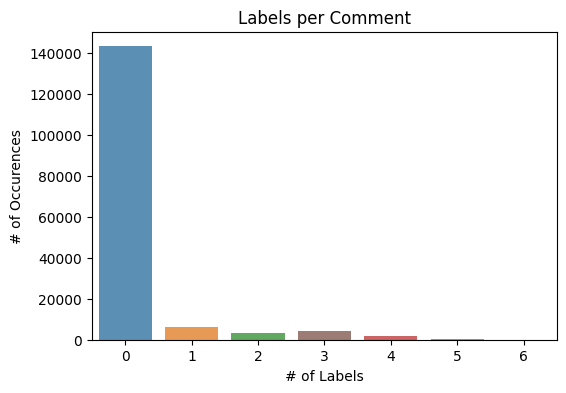

In [12]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Labels per Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

**Data Preprocessing**

In [13]:
df = df.drop(columns=['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
# remove stopwords
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# stemming
stemmer = SnowballStemmer('english')
def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
        
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [15]:
# preprocess the comment
df['comment_text'] = df['comment_text'].apply(lambda x: remove_stopwords(x))
df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))
df['comment_text'] = df['comment_text'].apply(lambda x: stemming(x))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0


In [16]:
# split input and output
X = df['comment_text']
y = df.drop(columns=['comment_text'], axis=1)

In [17]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test):
    # train model
    pipeline.fit(X_train, y_train)
    # predict from model
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    # print metrics
    print('roc_auc:', roc_auc_score(y_test, pred_probs))
    print('accuracy:', accuracy_score(y_test, predictions))
    print('classification report')
    print(classification_report(y_test, predictions, target_names=y_train.columns))

**Implementing Pipelines for Naive_Bayes and Logistic_Regeression**

In [19]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

In [20]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)


roc_auc: 0.8604178106899295
accuracy: 0.8997963340122199
classification report
               precision    recall  f1-score   support

        toxic       0.99      0.19      0.32      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.98      0.11      0.20      1715
       threat       1.00      0.01      0.03        74
       insult       0.97      0.05      0.10      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.12      0.22      7074
    macro avg       0.66      0.06      0.11      7074
 weighted avg       0.90      0.12      0.21      7074
  samples avg       0.02      0.01      0.01      7074



C:\Users\venki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

In [21]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)


roc_auc: 0.9788611968418081
accuracy: 0.9180322732257559
classification report
               precision    recall  f1-score   support

        toxic       0.90      0.62      0.74      3056
 severe_toxic       0.58      0.28      0.37       321
      obscene       0.92      0.64      0.75      1715
       threat       0.62      0.14      0.22        74
       insult       0.81      0.50      0.62      1614
identity_hate       0.70      0.16      0.26       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.75      0.39      0.50      7074
 weighted avg       0.86      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074



C:\Users\venki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

**Test Prediction**

In [22]:
labels = y_train.columns.values
labels

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [23]:
X_test.sample(1).values[0]


'wpphilippin class start import low'

In [24]:
sentence = 'You are really bigg piece of Pig SHIT'

stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     1
 identity_hate     0


In [25]:
sentence = 'This place is really shit and gross owner is a big pussy'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     0
 identity_hate     0


**ROC Curve**

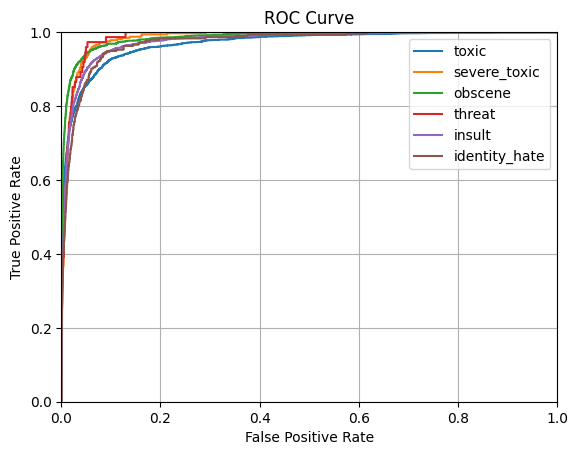

In [26]:
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)
    
def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    for label in labels:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

plot_pipeline_roc_curve(LR_pipeline, X_train, X_test, y_train, y_test)

In [27]:
import joblib
joblib.dump(LR_pipeline, 'toxic_comment_classifier.pkl')

['toxic_comment_classifier.pkl']